In [1]:
import pandas as pd
import subprocess
import os
import matplotlib.pyplot as plt


class GSATRunner:
    def __init__(self, dir_path, num_runs, rng_seed, max_literals=3):
        self.dir_path = dir_path
        self.files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
        self.iterations = [300]
        self.rng_seed = rng_seed
        self.max_literals = max_literals
        self.num_runs = num_runs
        self.results_df = pd.DataFrame()

    def extract_file_number(self, filename):
        return filename.split('-')[-1].split('.')[0]

    def process_result(self, result):
        first_line = result.stderr
        return list(map(int, first_line.split()[:4]))

    def run_command(self, cmd):
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        return self.process_result(result)

    def run(self):
        for file in self.files:
            print(f"================= CNF: {file} =================")
            file_num = self.extract_file_number(file)
            file_path = os.path.join(self.dir_path, file)
            for it in self.iterations:
                
                data = []
                
                for i in range(self.num_runs):
                    cmd = f"./solvers/gsat2 -r {(i + self.rng_seed)*self.rng_seed} -i {it} -w {self.max_literals} {file_path}"
                    result = self.run_command(cmd)
                    data.append([file_num, it] + result)

                temp_df = pd.DataFrame(data, columns=['FileNumber', 'iterations', 'FlipsResult', 'MaxFlipsResult', 'satisfiedC', 'TotalC'])
                temp_df["Solved"] = (temp_df["satisfiedC"] == temp_df["TotalC"]).astype(int)
                
                temp_row = pd.DataFrame({
                    'FileNumber': [temp_df['FileNumber'].iloc[0]],
                    'iterations': [temp_df['iterations'].iloc[0]],
                    'TotalCSum': [temp_df['TotalC'].sum()],
                    'MaxFlipsResultSum': [temp_df['MaxFlipsResult'].sum()],
                    'FlipsResultSum': [temp_df['FlipsResult'].sum()],
                    'satisfiedCSum': [temp_df['satisfiedC'].sum()],
                    'SolvedSum': [temp_df['Solved'].sum()],
                    'nOfRuns': [len(temp_df)],
                })
                
                self.results_df = pd.concat([self.results_df, temp_row], ignore_index=True)

        self.results_df.to_csv(f"results/gsat_{self.dir_path.split('/')[-1]}.csv", index=False)
        
class ProbSATRunner:
    def __init__(self, dir_path, num_runs, rng_seed):
        self.dir_path = dir_path
        self.files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
        self.iterations = [300]
        self.rng_seed = rng_seed
        self.num_runs = num_runs
        self.results_df = pd.DataFrame()

    def extract_file_number(self, filename):
        return filename.split('-')[-1].split('.')[0]

    def process_result(self, result):
        data = result.stdout
        lines = data.split('\n')
        numFlips = None
        maxFlips = None
        numClauses = None
        satisfiedClauses = None
        for line in lines:
            if 'c numFlips' in line:
                numFlips = int(line.split()[-1])
            elif 'c maxFlips' in line:
                maxFlips = int(line.split()[-1])
            elif 'c number of clauses' in line:
                numClauses = int(line.split()[-1])

        if 'UNKNOWN' not in data:
            satisfiedClauses = numClauses
        else:
            for line in reversed(lines):
                if 'UNKNOWN best(' in line:
                    unsatisfiedClauses = int(line.split('best(')[1].split(')')[0].strip())
                    satisfiedClauses = numClauses - unsatisfiedClauses
                    break

        first_line = f"{numFlips} {maxFlips} {satisfiedClauses} {numClauses}"
        return list(map(int, first_line.split()[:4]))


    def run_command(self, cmd):
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        return self.process_result(result)

    def run(self):
        for file in self.files:
            print(f"================= CNF: {file} =================")
            file_num = self.extract_file_number(file)
            file_path = os.path.join(self.dir_path, file)
            for it in self.iterations:
                
                data = []

                for i in range(self.num_runs):
                    cmd = f"./solvers/probSAT --fct 0 --eps 1.0 --maxflips {it} {file_path} {(i + self.rng_seed)*self.rng_seed}"
                    result = self.run_command(cmd)
                    data.append([file_num, it] + result)

                temp_df = pd.DataFrame(data, columns=['FileNumber', 'iterations', 'FlipsResult', 'MaxFlipsResult', 'satisfiedC', 'TotalC'])
                temp_df["Solved"] = (temp_df["satisfiedC"] == temp_df["TotalC"]).astype(int)
                        
                temp_row = pd.DataFrame({
                    'FileNumber': [temp_df['FileNumber'].iloc[0]],
                    'iterations': [temp_df['iterations'].iloc[0]],
                    'TotalCSum': [temp_df['TotalC'].sum()],
                    'MaxFlipsResultSum': [temp_df['MaxFlipsResult'].sum()],
                    'FlipsResultSum': [temp_df['FlipsResult'].sum()],
                    'satisfiedCSum': [temp_df['satisfiedC'].sum()],
                    'SolvedSum': [temp_df['Solved'].sum()],
                    'nOfRuns': [len(temp_df)],
                })              
                
                self.results_df = pd.concat([self.results_df, temp_row], ignore_index=True)

        self.results_df.to_csv(f"results/probsat_{self.dir_path.split('/')[-1]}.csv", index=False)
  
print()
print("GSAT uf20-91:")
GSATRunner(dir_path="data/uf20-91R", num_runs=1000, rng_seed=42).run()
print("GSAT uf50-218:")
GSATRunner(dir_path="data/uf50-218R", num_runs=1000, rng_seed=42).run()
print("GSAT uf75-325:")
GSATRunner(dir_path="data/uf75-325R", num_runs=1000, rng_seed=42).run()

print()
print("ProbSAT uf20-91:")
ProbSATRunner(dir_path="data/uf20-91R", num_runs=1000, rng_seed=42).run()
print("ProbSAT uf50-218:")
ProbSATRunner(dir_path="data/uf50-218R", num_runs=1000, rng_seed=42).run()
print("ProbSAT uf75-325:")
ProbSATRunner(dir_path="data/uf75-325R", num_runs=1000, rng_seed=42).run()


GSAT uf20-91:
================= CNF: uf20-0930.cnf =================
================= CNF: uf20-0371.cnf =================
================= CNF: uf20-0634.cnf =================
================= CNF: uf20-071.cnf =================
================= CNF: uf20-0804.cnf =================
================= CNF: uf20-0990.cnf =================
================= CNF: uf20-0327.cnf =================
================= CNF: uf20-0816.cnf =================
================= CNF: uf20-0747.cnf =================
================= CNF: uf20-0897.cnf =================
================= CNF: uf20-0280.cnf =================
================= CNF: uf20-0468.cnf =================
================= CNF: uf20-0314.cnf =================
================= CNF: uf20-0778.cnf =================
================= CNF: uf20-0232.cnf =================
================= CNF: uf20-0339.cnf =================
================= CNF: uf20-0780.cnf =================
================= CNF: uf20-0262.cnf ==============

In [4]:
gsat_20 = pd.read_csv("results/gsat_uf20-91R.csv")
gsat_50 = pd.read_csv("results/gsat_uf50-218R.csv")
gsat_75 = pd.read_csv("results/gsat_uf75-325R.csv")

probsat_20 = pd.read_csv("results/probsat_uf20-91R.csv")
probsat_50 = pd.read_csv("results/probsat_uf50-218R.csv")
probsat_75 = pd.read_csv("results/probsat_uf75-325R.csv")

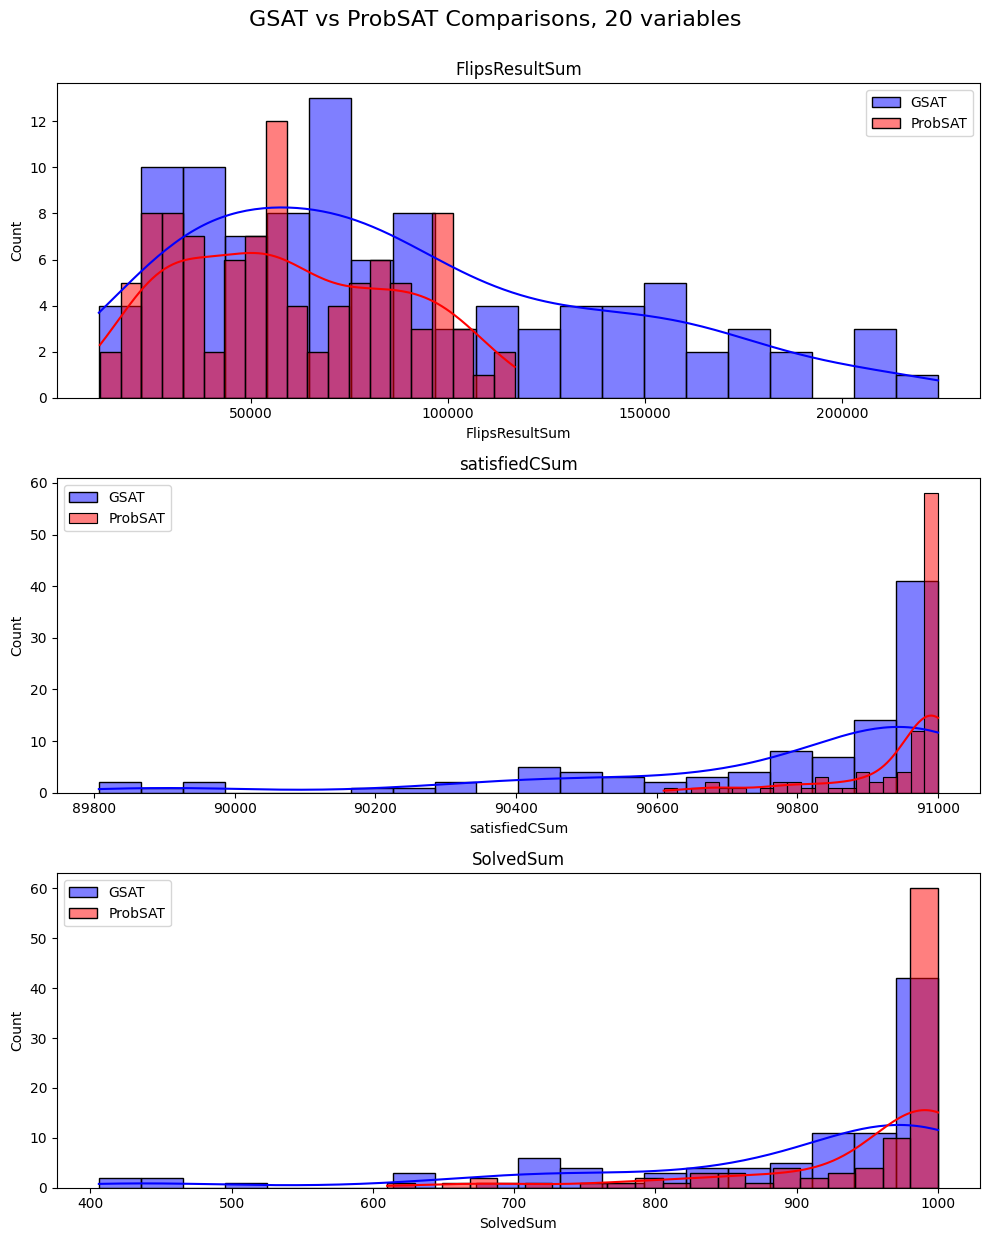

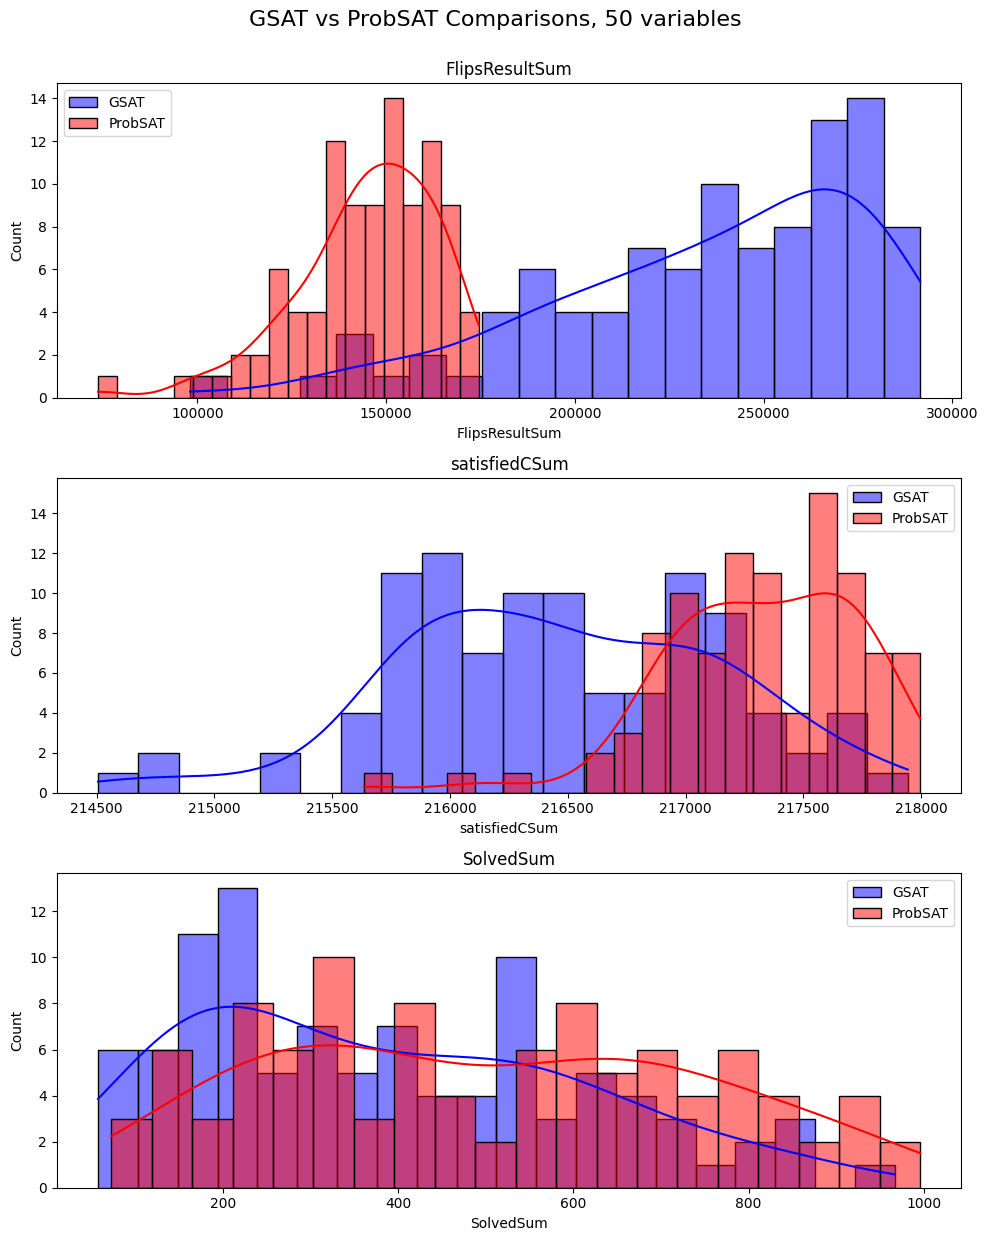

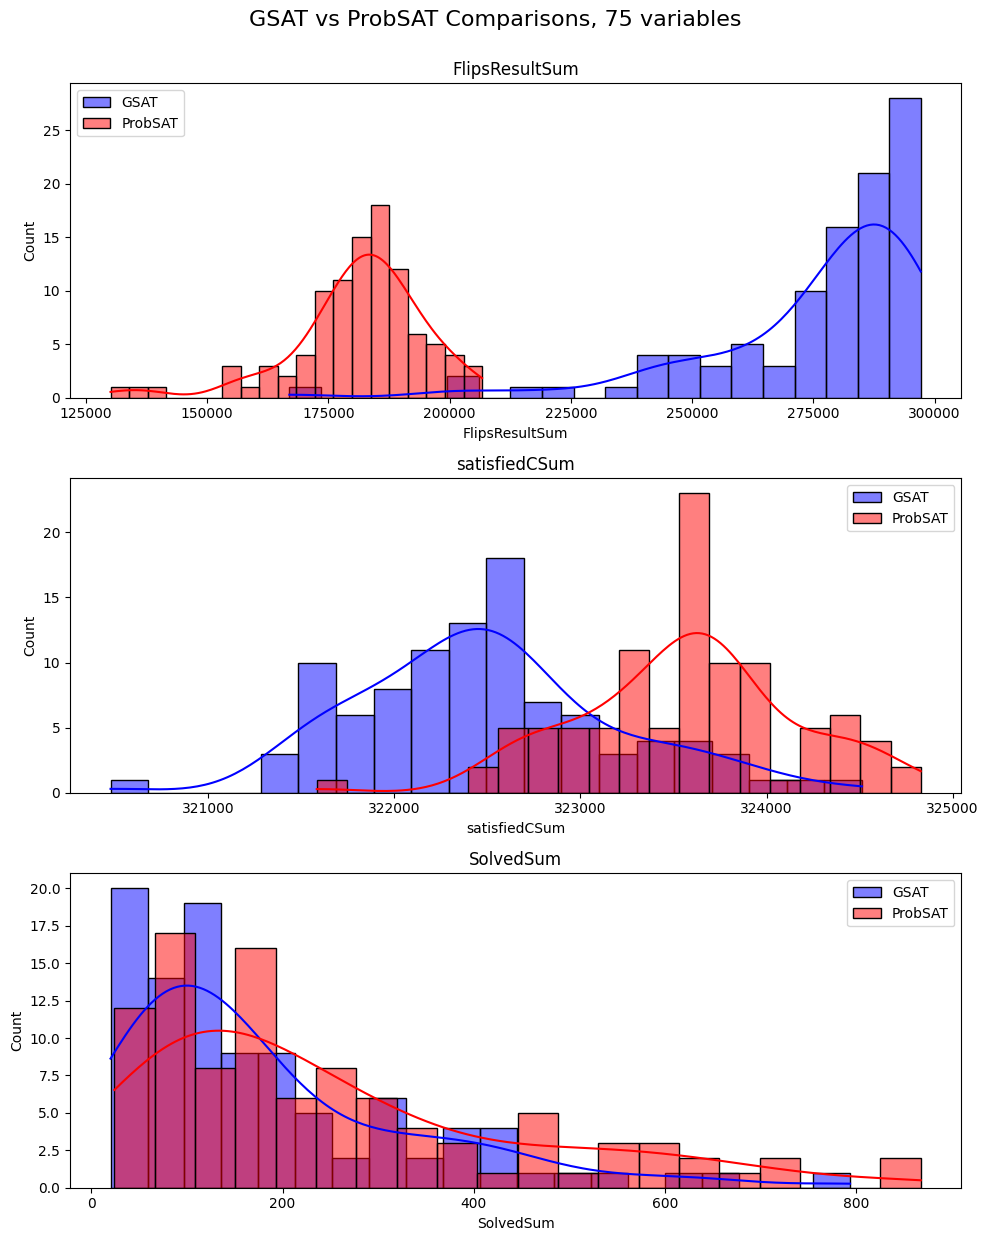

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(df1, df2, columns, n_var):
    num_rows = len(columns)
    fig, axes = plt.subplots(nrows=num_rows, ncols=1, figsize=(10, num_rows * 4))

    # Ensure axes is an array even when there's only one row
    if num_rows == 1:
        axes = [axes]

    for i, col in enumerate(columns):
        sns.histplot(df1[col], ax=axes[i], bins=20, color='blue', kde=True, label='GSAT')
        sns.histplot(df2[col], ax=axes[i], bins=20, color='red', kde=True, label='ProbSAT')
        axes[i].set_title(col)
        axes[i].legend()

    
    plt.tight_layout()
    fig.suptitle(f'GSAT vs ProbSAT Comparisons, {n_var} variables', fontsize=16, y=1.03)
    plt.show()

# Usage example
columns = ["FlipsResultSum", "satisfiedCSum", "SolvedSum"]
plot_histograms(gsat_20, probsat_20, columns, "20")
plot_histograms(gsat_50, probsat_50, columns, "50")
plot_histograms(gsat_75, probsat_75, columns, "75")


In [34]:
sum_gsat = pd.DataFrame([
    gsat_20.sum(axis=0)[columns],
    gsat_50.sum(axis=0)[columns],
    gsat_75.sum(axis=0)[columns],
])

sum_gsat.index = [20, 50, 75]

sum_probsat = pd.DataFrame([
    probsat_20.sum(axis=0)[columns],
    probsat_50.sum(axis=0)[columns],
    probsat_75.sum(axis=0)[columns],
])

sum_probsat.index = [20, 50, 75]

max_gsat = pd.DataFrame([
    gsat_20.max(axis=0)[columns],
    gsat_50.max(axis=0)[columns],
    gsat_75.max(axis=0)[columns],
])

max_gsat.index = [20, 50, 75]

max_probsat = pd.DataFrame([
    probsat_20.max(axis=0)[columns],
    probsat_50.max(axis=0)[columns],
    probsat_75.max(axis=0)[columns],
])

max_probsat.index = [20, 50, 75]

min_gsat = pd.DataFrame([
    gsat_20.min(axis=0)[columns],
    gsat_50.min(axis=0)[columns],
    gsat_75.min(axis=0)[columns],
])

min_gsat.index = [20, 50, 75]

min_probsat = pd.DataFrame([
    probsat_20.min(axis=0)[columns],
    probsat_50.min(axis=0)[columns],
    probsat_75.min(axis=0)[columns],
])

min_probsat.index = [20, 50, 75]

In [26]:
sum_gsat

,FlipsResultSum,satisfiedCSum,SolvedSum
20,8755645,9078144,89043
50,23552763,21645371,38485
75,27578678,32248886,18330


In [35]:
max_gsat

,FlipsResultSum,satisfiedCSum,SolvedSum
20,224336,91000,1000
50,291450,217943,967
75,297151,324513,794


In [36]:
min_gsat

,FlipsResultSum,satisfiedCSum,SolvedSum
20,11456,89807,406
50,98082,214506,57
75,166945,320475,20


In [27]:
sum_probsat

,FlipsResultSum,satisfiedCSum,SolvedSum
20,5949046,9094418,94684
50,14508804,21732099,50054
75,18143209,32356874,25270


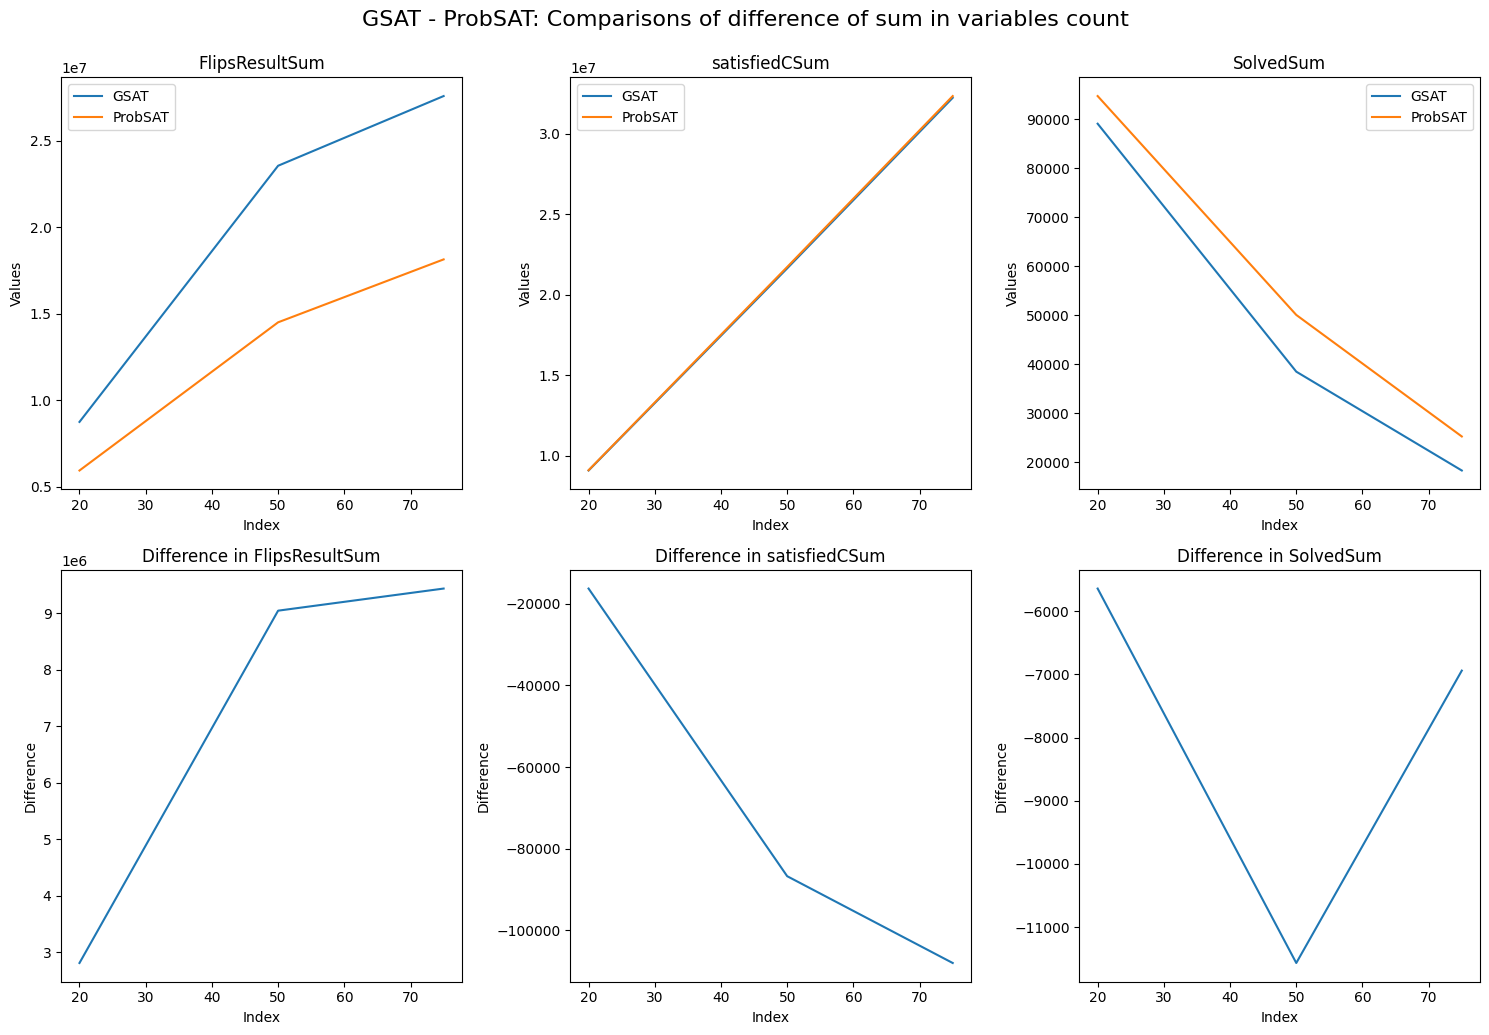

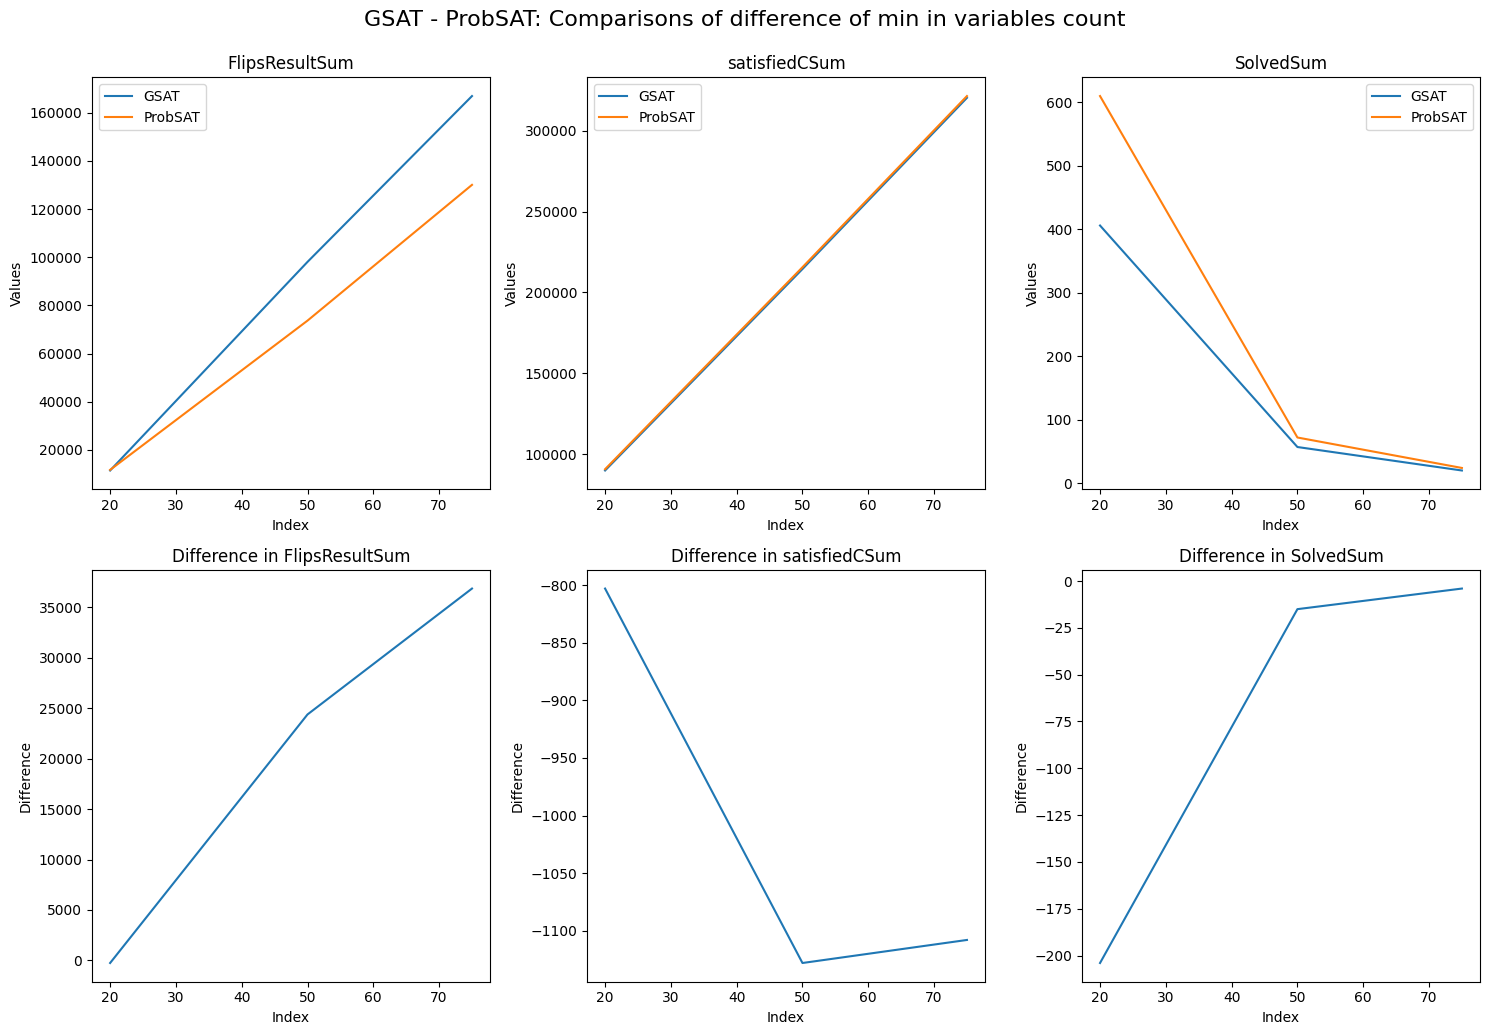

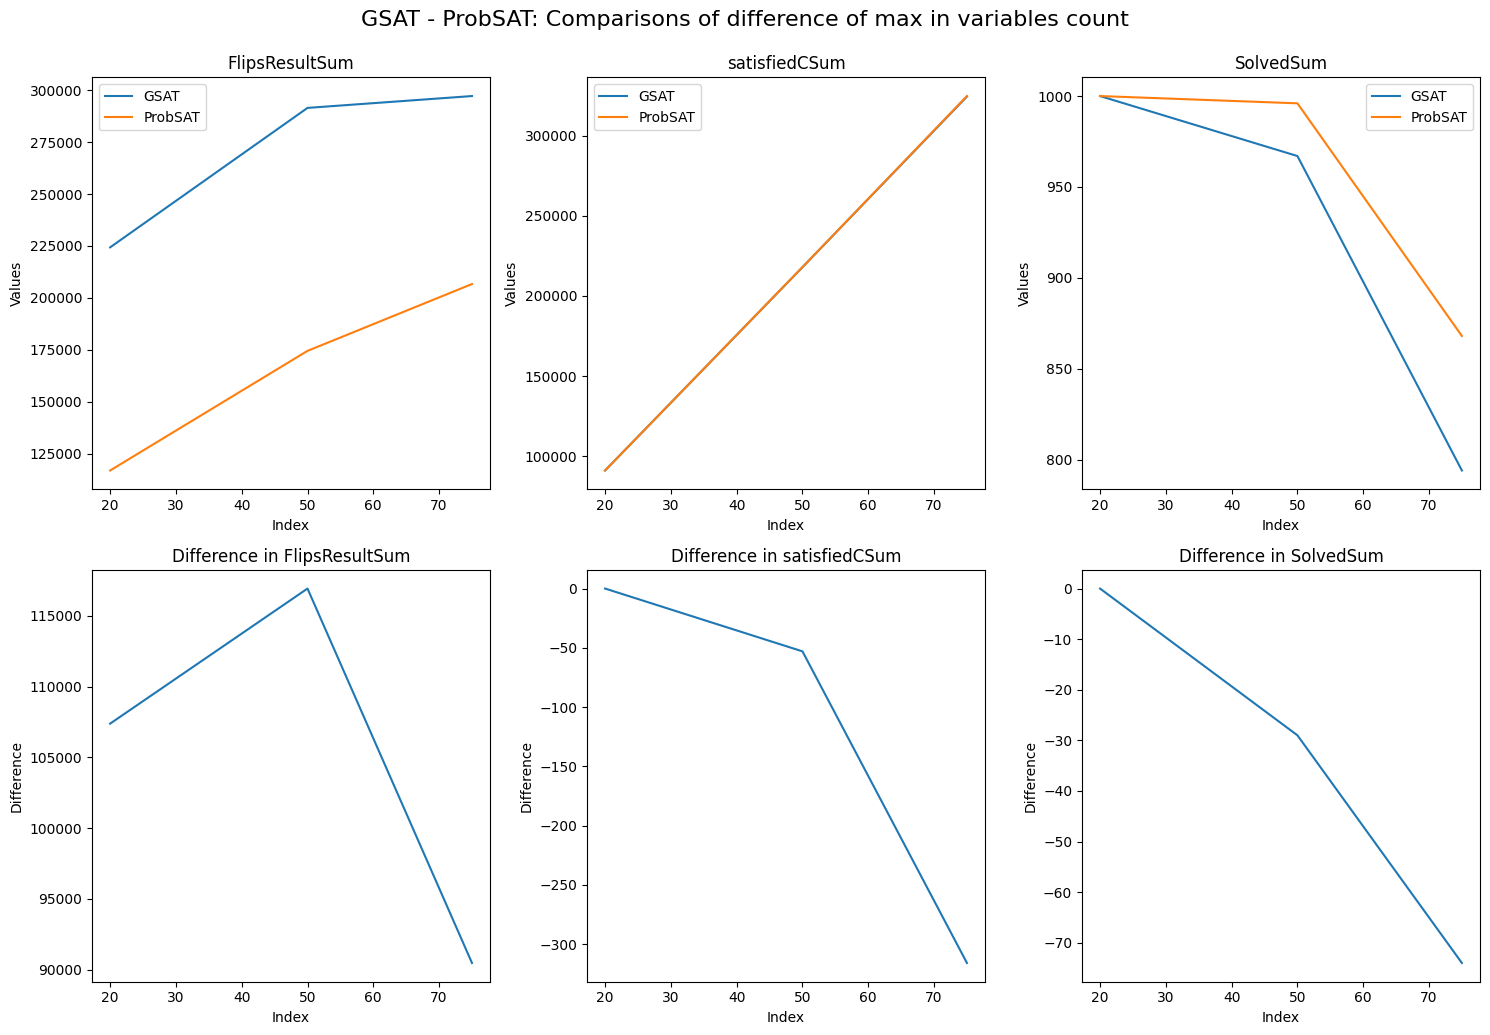

In [38]:
def plot_diff_between_dfs(df1, df2, title):
    # Plot df1 and df2
    fig, axes = plt.subplots(nrows=2, ncols=len(df1.columns), figsize=(15, 10))

    for i, col in enumerate(df1.columns):
        axes[0, i].plot(df1.index, df1[col], label='GSAT')
        axes[0, i].plot(df2.index, df2[col], label='ProbSAT')
        axes[0, i].set_title(col)
        axes[0, i].set_xlabel('Index')
        axes[0, i].set_ylabel('Values')
        axes[0, i].legend()

    # Plot difference
    diff_df = abs(df1 - df2)
    for i, col in enumerate(diff_df.columns):
        axes[1, i].plot(diff_df.index, diff_df[col])
        axes[1, i].set_title(f'|Difference| in {col}')
        axes[1, i].set_xlabel('Index')
        axes[1, i].set_ylabel('Difference')

    plt.tight_layout()
    fig.suptitle(title, fontsize=16, y=1.03)
    plt.show()

plot_diff_between_dfs(sum_gsat, sum_probsat, "GSAT - ProbSAT: Comparisons of difference of sum in variables count")
plot_diff_between_dfs(min_gsat, min_probsat, "GSAT - ProbSAT: Comparisons of difference of min in variables count")
plot_diff_between_dfs(max_gsat, max_probsat, "GSAT - ProbSAT: Comparisons of difference of max in variables count")

In [ ]:
gsat